# Learning XOR with Pytorch

This notebook provides a neural network that learns the XOR logic operation:

|   x1  |   x2  |  y  |
|:-----:|:-----:|:---:|
|   1   |   1   |  0  |
|   1   |   0   |  1  |
|   0   |   1   |  1  |
|   0   |   0   |  0  |

This example is will provide an insight into a simple neural network and, at the same time, a gentle introduction to [PyTorch](https://pytorch.org).

## Importing the libraries

In [1]:
# import libraries 
import torch
import torch.nn as nn
from torch.autograd import Variable

## Device

PyTorch can use both CPU or GPU, depending on what is available:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Dataset

The training dataset is composed of the inputs and required outputs of the neural network. In this case, the inputs are represented in a [tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) of $4 \times 2$ dimension and the output (labels) in a $4 \times 1$ tensor.

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, tensors are used to encode the inputs and outputs of a model, as well as the model’s parameters. We are also using a [`Dataset`](https://pytorch.org/docs/1.10.0/data.html#iterable-style-datasets) with the `DataLoader` to iterate the training set.

In [3]:
from torch.utils.data import Dataset

class XorDataset(Dataset):
    def __init__(self):
        self.Xs = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])
        self.y = torch.Tensor([0., 1., 1., 0.])
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        image = self.Xs[idx]
        label = self.y[idx]
        return image, label
    


In [4]:
from torch.utils.data import DataLoader

training_data = XorDataset()
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
feature = train_features[0]
label = train_labels[0]
print(f"Features: {feature}; Label: {label}")

Feature batch shape: torch.Size([1, 2])
Labels batch shape: torch.Size([1])
Features: tensor([0., 0.]); Label: 0.0


## Neural Network

The neural network is defined by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

For the XOR network, we need two layers (refer to the slides).

In [6]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear_xor_stack = nn.Sequential(
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_xor_stack(x)
        return logits

The neural network is instanciated by creating the class and associating it to a processing device:

In [7]:
xor_network = XOR()
model = xor_network.to(device)
print(model)

XOR(
  (linear_xor_stack): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


After the definition of the dataset and model architecture, we can train the network. We're using backpropagation, as depicted below:

In [9]:
from torch.utils.data import DataLoader
all_losses=[]
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    all_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")   

We are using Min Square Error loss function and Stochastic Gradient Descent for training with 2000 epochs.

In [10]:
learning_rate = 1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 2000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.262443  [    0/    4]
loss: 0.370690  [    1/    4]
loss: 0.218594  [    2/    4]
loss: 0.414682  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250035 

Epoch 2
-------------------------------
loss: 0.249697  [    0/    4]
loss: 0.380977  [    1/    4]
loss: 0.227875  [    2/    4]
loss: 0.404646  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250097 

Epoch 3
-------------------------------
loss: 0.243766  [    0/    4]
loss: 0.384919  [    1/    4]
loss: 0.232698  [    2/    4]
loss: 0.398831  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250144 

Epoch 4
-------------------------------
loss: 0.241064  [    0/    4]
loss: 0.385801  [    1/    4]
loss: 0.235297  [    2/    4]
loss: 0.395081  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.250163 

Epoch 5
-------------------------------
loss: 0.239917  [    0/    4]
loss: 0.385191  [    1/    4]
loss: 0.236800  [    2/    4]
loss: 0.392336  [    3

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.094794  [    0/    4]
loss: 0.215215  [    1/    4]
loss: 0.175670  [    2/    4]
loss: 0.459586  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.209400 

Epoch 195
-------------------------------
loss: 0.092320  [    0/    4]
loss: 0.212832  [    1/    4]
loss: 0.173791  [    2/    4]
loss: 0.461933  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.208567 

Epoch 196
-------------------------------
loss: 0.089888  [    0/    4]
loss: 0.210467  [    1/    4]
loss: 0.171927  [    2/    4]
loss: 0.464243  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.207744 

Epoch 197
-------------------------------
loss: 0.087501  [    0/    4]
loss: 0.208125  [    1/    4]
loss: 0.170082  [    2/    4]
loss: 0.466512  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.206932 

Epoch 198
-------------------------------
loss: 0.085160  [    0/    4]
loss: 0.205811  [    1/    4]
loss: 0.168258  [    2/    4]
loss: 0.468737  [    3/    4]
Test Error: 
 Accuracy: 

Let's plot the loss function:

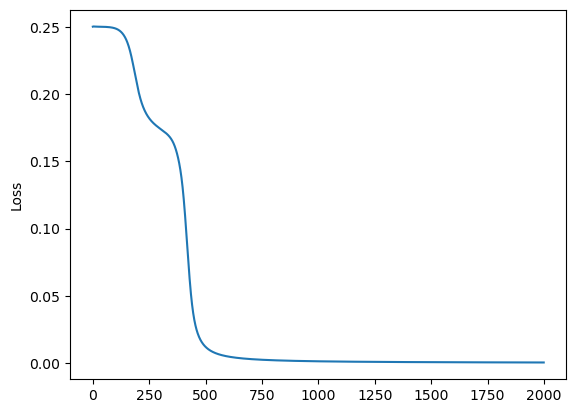

In [11]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.ylabel('Loss')
plt.show()

We can now check the network parameters:

In [12]:
# show weights and bias
for name, param in xor_network.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear_xor_stack.0.weight tensor([[-6.5389, -6.6326],
        [-4.6609, -4.6727]])
linear_xor_stack.0.bias tensor([2.6703, 6.9317])
linear_xor_stack.2.weight tensor([[-9.5294,  9.4108]])
linear_xor_stack.2.bias tensor([-4.4483])


## Check the model

Let's check if the model behaves as expected:

In [13]:
# test input
input = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])
out = xor_network.forward(input)
print(out.round())

tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)
